In [2]:
using TestImages, Images, QuartzImageIO, ImageView

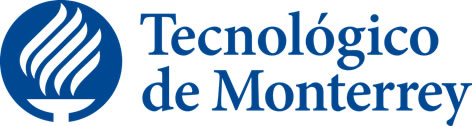

In [3]:
img = load("tec-logo.jpg")

## Optimal Power Demand

Power demand in a medium size city is met using a combination of thermal power (TP) and combined cycle
(CC) plants. Commonly, conventional thermal power plants  deploy oil, whereas combined cycle power plants run
on natural gas. However, as shown in the next figure,  the first thermal power plant (TP$_1$) actually deploys a combination of both natural gas and oil. 

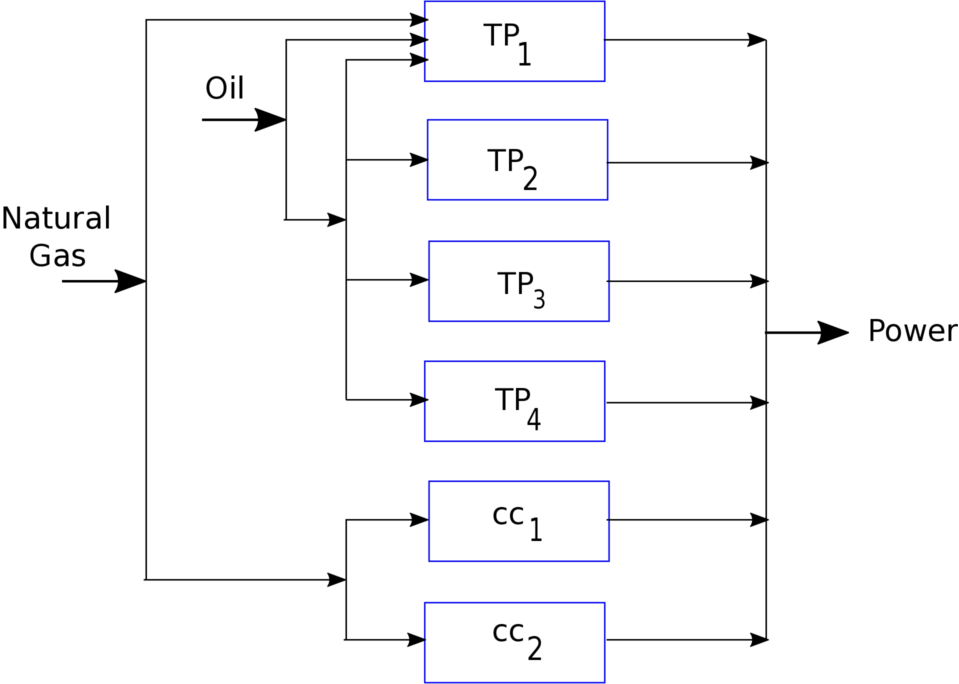

In [4]:
img = load("NP_fig1.png")

Even when normally power demand changes over a typical working day, by the time being
we will assume that power demand is constant and set at 27,000 MWH. We will also assume  limiting availability of  natural gas and oil  of 14,400 and 18,000 m$^3$/h, respectively. Power profit is assumed to be 5 USD/MW, while the costs of 
natural gas and oil are 1 and 0.5 USD/MW, respectively. 
You should also note that each power plant can only process a maximum 
load of raw material. You are asked to determine the optimal distribution of gas natural and oil such that power profit is maximized. 

| Plant  |           Efficiency [Mw/m$^3$]|   Operating Cost [\$/MW] | Maximum Load [m$^3$/h]|
|:------:|:-------:|:----------------:|:-----------:|
| TP$_1$ | 1(G) 0.5(O) | 0.05  | 7000(G), 8000(O) |
|TP$_2$  | 0.8         | 0.03  |  7500 |
|TP$_3$  | 0.6         |  0.08 |  8500 |
|TP$_4$  |  0.7        | 0.07  | 7300  |
|CC$_1$  | 1.2         | 0.05  | 9500  |
|CC$_2$  | 1.3         |  0.04 |  12000  |

At each power plant, output power ($P$) [MWH ]is calculated as follows:
$$ P_i = \eta _i \cdot F^f_i, \quad i=TP_1,...,CC_2 $$
where $F^f$ is the entering flowrate of fuel [m$^3$/h].


In [14]:
using JuMP, Clp, Plots, Printf

In [15]:
power_networkplant = Model(solver=ClpSolver());

In [16]:
eta1_pp1 = 1  # Plant efficiency [MW/m3]
eta2_pp1 = 0.5
eta_pp2  = 0.8
eta_pp3  = 0.6
eta_pp4  = 0.7
eta_cc1  = 1.2
eta_cc2  = 1.3 ;

Power_demand = 27000  # [MW/h]

Profit_power = 5 # [$/MW]
cost_gas     = 1 # [$/MW]
cost_oil     = 0.5 # [$/MW]
cost_pp1     = 0.05 
cost_pp2     = 0.03 
cost_pp3     = 0.08
cost_pp4     = 0.07
cost_pc1     = 0.05
cost_pc2     = 0.04

load_pp1_g   = 7000 # [m3/h]
load_pp1_o   = 8000 # [m3/h]
load_pp2     = 7500 # [m3/h]
load_pp3     = 8500 # [m3/h]
load_pp4     = 7300 # [m3/h]
load_pc1     = 9500 # [m3/h]
load_pc2     = 12000 # [m3/h]

fg_available = 14400 # [m3/h]
fo_available = 18000 # [m3/h];

In [17]:
@variable(power_networkplant, fg    >= 0, start = 1000)  # [m3/h]
@variable(power_networkplant, fg1   >= 0, start = 1000)  # [m3/h]
@variable(power_networkplant, fg2   >= 0, start = 1000)  # [m3/h]
@variable(power_networkplant, fg21  >= 0, start = 1000)  # [m3/h]
@variable(power_networkplant, fg22  >= 0, start = 1000)  # [m3/h]

@variable(power_networkplant, fo    >= 0, start = 1000)  # [m3/h]
@variable(power_networkplant, fo1   >= 0, start = 1000)  # [m3/h]
@variable(power_networkplant, fo2   >= 0, start = 1000)  # [m3/h]
@variable(power_networkplant, fo21  >= 0, start = 1000)  # [m3/h]
@variable(power_networkplant, fo22  >= 0, start = 1000)  # [m3/h]
@variable(power_networkplant, fo23  >= 0, start = 1000)  # [m3/h]
@variable(power_networkplant, fo24  >= 0, start = 1000)  # [m3/h]

@variable(power_networkplant, P_pe1 >= 0, start = 1000)  # [m3/h]
@variable(power_networkplant, P_pe2 >= 0, start = 1000)  # [m3/h]
@variable(power_networkplant, P_pe3 >= 0, start = 1000)  # [m3/h]
@variable(power_networkplant, P_pe4 >= 0, start = 1000)  # [m3/h]
@variable(power_networkplant, P_cc1 >= 0, start = 1000)  # [m3/h]
@variable(power_networkplant, P_cc2 >= 0, start = 1000)  # [m3/h]
@variable(power_networkplant, P_tot >= 0, start = 1000)  # [m3/h];

#### Mass balance constraints for gas running plants

In [18]:
@constraint(power_networkplant, c1,   fg   == fg1 + fg2       )
@constraint(power_networkplant, c2,   fg1  <= fg              )
@constraint(power_networkplant, c3,   fg2  <= fg              )
@constraint(power_networkplant, c4,   fg2  == fg21   + fg22   )
@constraint(power_networkplant, c5,   fg21 <= fg2             )
@constraint(power_networkplant, c6,   fg22 <= fg2             );

#### Mass balance constraints for oil running plants

In [19]:
@constraint(power_networkplant, c7,   fo   == fo1 +       fo2 )
@constraint(power_networkplant, c8,   fo1  <= fo              )
@constraint(power_networkplant, c9,   fo2  <= fo              )
@constraint(power_networkplant, c10,  fo2  == fo21 + fo22 + fo23 + fo24 )
@constraint(power_networkplant, c11, fo21 <= fo2              )
@constraint(power_networkplant, c12, fo22 <= fo2              )
@constraint(power_networkplant, c13, fo23 <= fo2              )
@constraint(power_networkplant, c14, fo24 <= fo2              );

#### Power manufacture

In [20]:
@constraint(power_networkplant, c15,   P_pe1   == eta1_pp1*fg1 + eta2_pp1*(fo1+fo21) )
@constraint(power_networkplant, c16,   P_pe2   == eta_pp2*fo22 )
@constraint(power_networkplant, c17,   P_pe3   == eta_pp3*fo23 )
@constraint(power_networkplant, c18,   P_pe4   == eta_pp4*fo24 )
@constraint(power_networkplant, c19,   P_cc1   == eta_cc1*fg21 )
@constraint(power_networkplant, c20,   P_cc2   == eta_cc2*fg22 )
@constraint(power_networkplant, c21,   P_tot   == P_pe1+P_pe2+P_pe3+P_pe4+P_cc1+P_cc2 );

#### Maximum capacity  constraints

In [21]:
@constraint(power_networkplant, c23,   fg1      <= load_pp1_g )
@constraint(power_networkplant, c24,   fo1+fo21 <= load_pp1_o )
@constraint(power_networkplant, c25,   fo22     <= load_pp2   )
@constraint(power_networkplant, c26,   fo23     <= load_pp3   )
@constraint(power_networkplant, c27,   fo24     <= load_pp4   )
@constraint(power_networkplant, c28,   fg21     <= load_pc1   )
@constraint(power_networkplant, c29,   fg22     <= load_pc2   );

#### Maximum raw material availability [m3/h]

In [22]:
@constraint(power_networkplant, c30,   fg   <= fg_available )
@constraint(power_networkplant, c31,   fo   <= fo_available );

#### Power demand

In [23]:
@constraint(power_networkplant, c32,   P_tot   <= Power_demand );

In [24]:
@objective(power_networkplant, Max, Profit_power*P_tot - cost_gas*fg - cost_oil*fo - cost_pp1*P_pe1 - 
           cost_pp2*P_pe2 - cost_pp3*P_pe3 - cost_pp4*P_pe4 - cost_pc1*P_cc1 - cost_pc2*P_cc2);

In [25]:
status_power_networkplant = solve(power_networkplant)

:Optimal

In [26]:
println("Objective function value = ", getobjectivevalue(power_networkplant))

@printf " fg   : %f\n" getvalue(fg)
@printf " fg1  : %f\n" getvalue(fg1)
@printf " fg2  : %f\n" getvalue(fg2)
@printf " fg21 : %f\n" getvalue(fg21)
@printf " fg22 : %f\n" getvalue(fg22)
@printf " fo1  : %f\n" getvalue(fo1)
@printf " fo2  : %f\n" getvalue(fo2)
@printf " fo21 : %f\n" getvalue(fo21)
@printf " fo22 : %f\n" getvalue(fo22)
@printf " fo23 : %f\n" getvalue(fo23)
@printf " fo24 : %f\n" getvalue(fo24)
@printf " fo   : %f\n" getvalue(fo)
@printf " P_pe1: %f\n" getvalue(P_pe1)
@printf " P_pe2: %f\n" getvalue(P_pe2)
@printf " P_pe3: %f\n" getvalue(P_pe3)
@printf " P_pe4: %f\n" getvalue(P_pe4)
@printf " P_cc1: %f\n" getvalue(P_cc1)
@printf " P_cc2: %f\n" getvalue(P_cc2)
@printf " P_tot: %f\n" getvalue(P_tot)


Objective function value = 114182.13333333333
 fg   : 12241.666667
 fg1  : 0.000000
 fg2  : 12241.666667
 fg21 : 241.666667
 fg22 : 12000.000000
 fo1  : 0.000000
 fo2  : 14800.000000
 fo21 : 0.000000
 fo22 : 7500.000000
 fo23 : 0.000000
 fo24 : 7300.000000
 fo   : 14800.000000
 P_pe1: 0.000000
 P_pe2: 6000.000000
 P_pe3: 0.000000
 P_pe4: 5110.000000
 P_cc1: 290.000000
 P_cc2: 15600.000000
 P_tot: 27000.000000
